In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xgb
import speedml as sml
import seaborn as sns
import chartify
import matplotlib.pyplot as plot
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import mlxtend
from pandas.io.json import json_normalize
# ignore warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss,roc_auc_score
sns.set(font_scale=1.56)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Loading BokehJS ...

In [2]:
# square scale
import matplotlib.scale as mscale
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import numpy as np

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """

    name = 'squareroot'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.array(a)**0.5

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.array(a)**2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)

In [3]:
from wordcloud import WordCloud
import matplotlib
from PIL import Image

In [4]:
df_basket = pd.read_csv('basket_analysis.csv')
df_basket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18413 entries, 0 to 18412
Data columns (total 9 columns):
itemName          18413 non-null object
price             18413 non-null float64
quantity          18413 non-null int64
subtotal          18413 non-null float64
date              18413 non-null object
time              18413 non-null object
receipt_id        18413 non-null object
total             18413 non-null float64
payment_method    18411 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 1.3+ MB


In [5]:
df_basket.describe()
df_basket.describe(include=['O'])

price      quantity      subtotal         total
count  18413.000000  18413.000000  18413.000000  18413.000000
mean       4.372123      1.394775      5.424293     33.977100
std        6.651230      2.200065      9.391569     52.695915
min        0.200000     -2.000000    -14.700000      0.000000
25%        1.600000      1.000000      2.000000      9.500000
50%        2.600000      1.000000      3.300000     17.150000
75%        5.100000      1.000000      5.700000     33.100000
max      108.900000    240.000000    330.000000    421.800000

itemName        date      time receipt_id payment_method
count       18413       18413     18413      18413          18411
unique       3681          27      5112       5445              2
top     EGGS 30'S  2018-09-30  13:14:05  T3-762316           Cash
freq          344        1211        53         53          13991

In [6]:
df_basket['itemName'] = df_basket['itemName'].str.lower()
df_basket.head()

itemName  price  quantity  subtotal  \
0               kampong salted chicken 800g   14.8         1      14.8   
1  yeo's chrysanthemum luo han guo tea 1.5l    1.0         1       1.0   
2  friso 4 gold 1.8kg (3 years onwards) new   59.5         1      59.5   
3        chicken sausage - valley chef 340g    2.8         1       2.8   
4                 myojo ramen charmee 5x80g    2.0         1       2.0   

         date      time receipt_id  total payment_method  
0  2018-09-01  07:34:45  T3-733343  15.80           Cash  
1  2018-09-01  07:34:45  T3-733343  15.80           Cash  
2  2018-09-01  07:38:54  T3-733346  70.45           Cash  
3  2018-09-01  07:38:54  T3-733346  70.45           Cash  
4  2018-09-01  07:38:54  T3-733346  70.45           Cash

## Top 10 Data Science Use Cases in Retail

*  Recommendatio engines
* Market basket anaysis
* Warranty analytics
* Price optimization
* Invertory management
* Location of new stores
* Custormer sentiment analysis
* Lifetime value prediction
* Fraud detection

## clustering

In [91]:
df_basket['category_exp_1'] = df_basket.itemName.str.split()
df_basket['category_exp_1'] = df_basket['category_exp_1'].map(lambda x: [ i for i in x if i.isalpha() == True] )
df_basket['category_exp_1'] = df_basket['category_exp_1'].str.join(' ')

In [92]:
import nltk

words = nltk.word_tokenize('And now for something completely different')
print(words)
word_tag = nltk.pos_tag(words)
print(word_tag)

['And', 'now', 'for', 'something', 'completely', 'different']
[('And', 'CC'), ('now', 'RB'), ('for', 'IN'), ('something', 'NN'), ('completely', 'RB'), ('different', 'JJ')]


In [93]:
%%time
df_basket['category_pos_tag'] = df_basket['category_exp_1'].map(lambda x: nltk.pos_tag(
                                                              nltk.word_tokenize(x)
                                                              ))
df_basket['category_extract'] = df_basket['category_pos_tag'].map(lambda x: [ i[0] for i in x if i[1] == 'NN' or i[1] == 'NNS'] )
df_basket['category_extract'] = df_basket['category_extract'].str.join(sep=' ')

Wall time: 2min 21s


In [94]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
print(stemmer.stem("eggs"))

egg


In [95]:
# df_basket['category_extract']
df_basket['category_extract'] = (df_basket['category_extract']
                                        .map(lambda x: " ".join([stemmer.stem(i) for i in x.lower().split()])))
df_basket['category_extract'].nunique()
df_basket[['itemName','category_exp_1','category_extract']].head()

2919

itemName                 category_exp_1  \
0               kampong salted chicken 800g         kampong salted chicken   
1  yeo's chrysanthemum luo han guo tea 1.5l  chrysanthemum luo han guo tea   
2  friso 4 gold 1.8kg (3 years onwards) new           friso gold years new   
3        chicken sausage - valley chef 340g    chicken sausage valley chef   
4                 myojo ramen charmee 5x80g            myojo ramen charmee   

             category_extract  
0                     chicken  
1             luo han guo tea  
2                   gold year  
3  chicken sausag valley chef  
4                 myojo ramen

In [96]:
df_basket['itemName'].nunique()
df_basket['category_extract'].nunique()

3681

2919

## Data Cleaning

## Anomaly analysis

In [7]:
# get back 
get_back_df = df_basket[df_basket.quantity < 0]
df_basket = df_basket[df_basket.quantity > 0]
get_back_df

itemName  price  quantity  subtotal  \
875    hollyfarm konnyaku jelly pwd 120g    1.6        -2      -3.2   
9652       whisper reg flow 20s non-wing    3.4        -1      -3.4   
16776              cap layang-layang 7kg   14.7        -1     -14.7   

             date      time receipt_id  total payment_method  
875    2018-09-01  16:51:58  T3-733975    0.0            NaN  
9652   2018-09-13  19:39:29  T3-745515    2.7           Cash  
16776  2018-09-29  11:57:23  T3-761080    7.8           Cash

## How does my store work?

In [8]:
# df_basket.head(100)
print('monthly total revenue:', df_basket.subtotal.sum())
this_month_revenue = df_basket.subtotal.sum()


monthly total revenue: 99786.3


In [9]:
df_basket.groupby(by=['receipt_id'],as_index=False).head(1).query('total == 0')

itemName  price  quantity  subtotal        date  \
876  hollyfarm ice jelly pwd 120g    1.6         2       3.2  2018-09-01   

         time receipt_id  total payment_method  
876  16:51:58  T3-733975    0.0            NaN

In [10]:
df_basket.groupby(by=['receipt_id'],as_index=False).head(1).total.describe()

count    5445.000000
mean       17.786988
std        24.790060
min         0.000000
25%         6.500000
50%        11.400000
75%        19.500000
max       421.800000
Name: total, dtype: float64

In [11]:
# what are the most popular item of store?
# 熱門商品
sns.set(font_scale=2)
# top 20 item buyed
result_top20_hot_item = df_basket[['itemName','quantity','subtotal']].groupby(by=['itemName']).sum().sort_values(by='quantity',ascending=False).head(20)
top_20_hot_revenue = np.around(result_top20_hot_item.subtotal.sum(),decimals=2)
top_20_hot_revenue_ratio = 100*np.around(top_20_hot_revenue / this_month_revenue,decimals=4)
print(top_20_hot_revenue)
print(top_20_hot_revenue_ratio)

9515.3
9.54


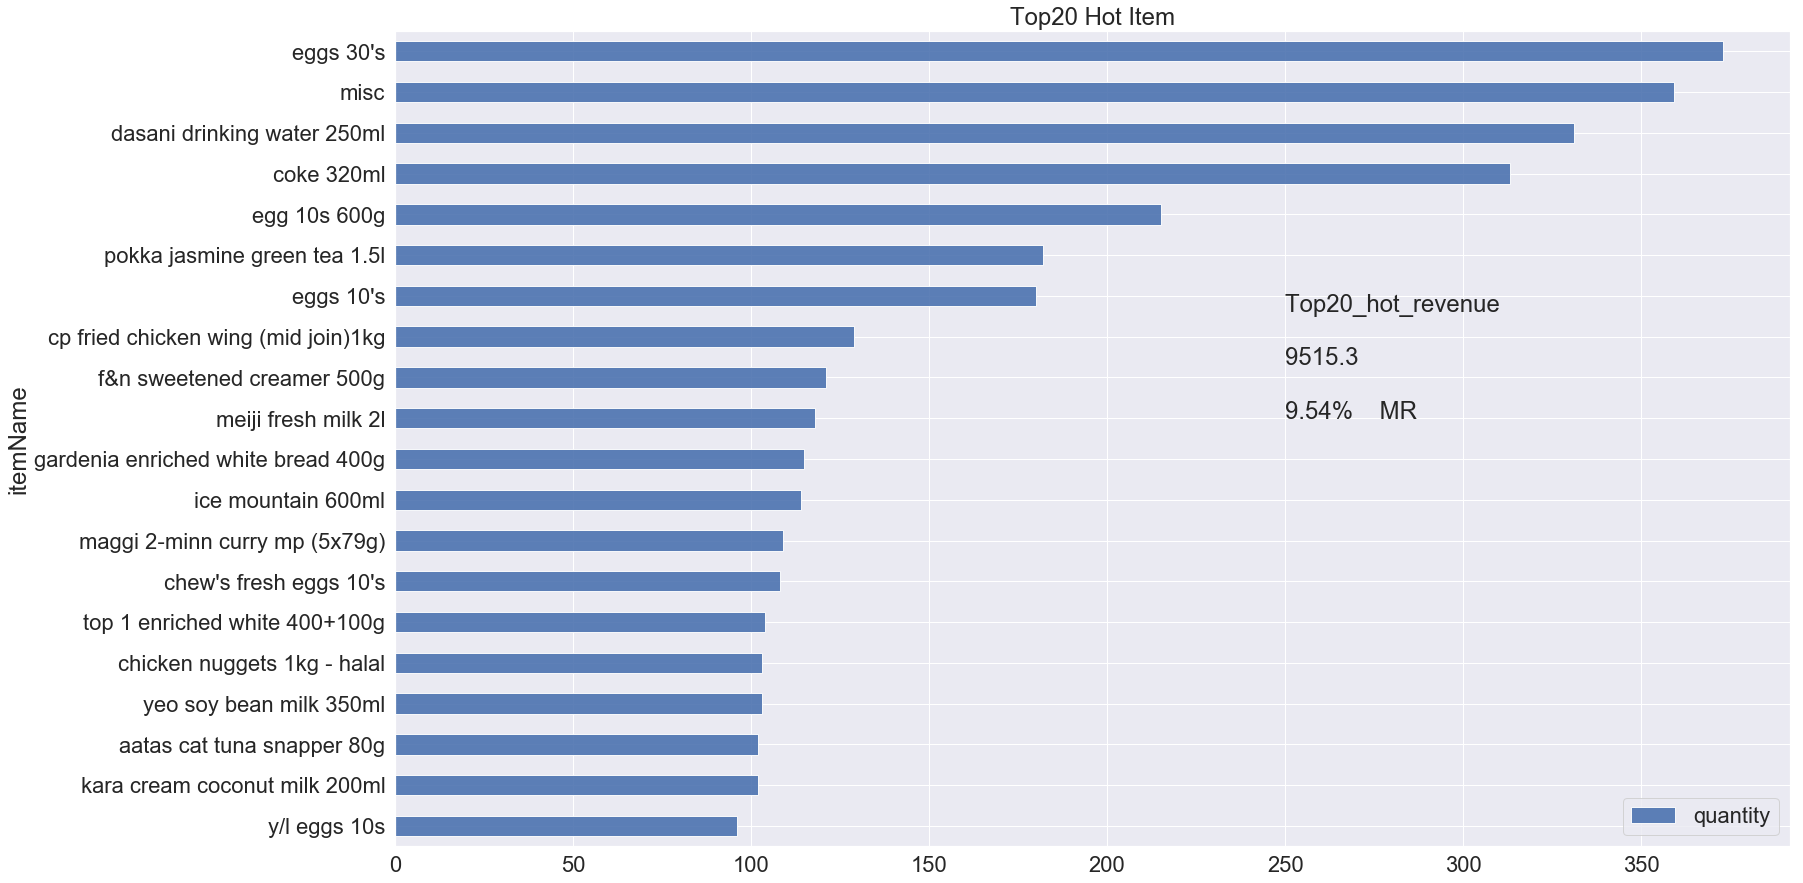

In [12]:
ax = result_top20_hot_item.drop(labels=['subtotal'],axis=1)\
.plot(kind='barh',figsize=(25,15),color='b',
                          alpha=.9,title='Top20 Hot Item')
ax.text(250,9, 'Top20_hot_revenue   \n\n'+str(top_20_hot_revenue)
       +'\n\n' + str(top_20_hot_revenue_ratio)+'%' + '    MR')
ax.invert_yaxis()

In [13]:
tidy_top20_hot_items = result_top20_hot_item.drop(labels=['subtotal'],axis=1).reset_index()
tidy_top20_hot_items.head()

itemName  quantity
0                    eggs 30's       373
1                         misc       359
2  dasani drinking water 250ml       331
3                   coke 320ml       313
4                 egg 10s 600g       215

In [14]:
InteractiveShell.ast_node_interactivity = "last_expr"

In [15]:
# tidy_top20_hot_items

In [16]:
# barh
# pass y_axis
ch = chartify.Chart(y_axis_type='categorical',blank_labels=True,layout='slide_100%')
ch.plot.bar(data_frame=tidy_top20_hot_items,
       categorical_columns='itemName',
       numeric_column='quantity',
        color_column='itemName',
        categorical_order_ascending=True)

ch.plot.text(data_frame=tidy_top20_hot_items,
           categorical_columns='itemName',
           numeric_column='quantity',
           text_column='quantity',
           categorical_order_ascending=True)
ch.set_title('Top 20 hottest items')
ch.axes.set_xaxis_label('quantity')
ch.axes.set_yaxis_label('item')
ch.axes.set_xaxis_range(0,400)
# hide axis
ch.axes.hide_xaxis()
ch.show()

In [17]:
# what are the least popular items of store?
sns.set(font_scale=2)
# top 20 item buyed
result_top20_revenue_item = df_basket[['itemName','subtotal']].groupby(by=['itemName']).sum().sort_values(by='subtotal',ascending=False).head(20)
top_20_revenue = np.around(result_top20_revenue_item.subtotal.sum(),decimals=2)
top_20_revenue_ratio = 100 * np.around((top_20_revenue / this_month_revenue),decimals=3)
print(top_20_revenue)
print(top_20_revenue_ratio)

15705.55
15.7


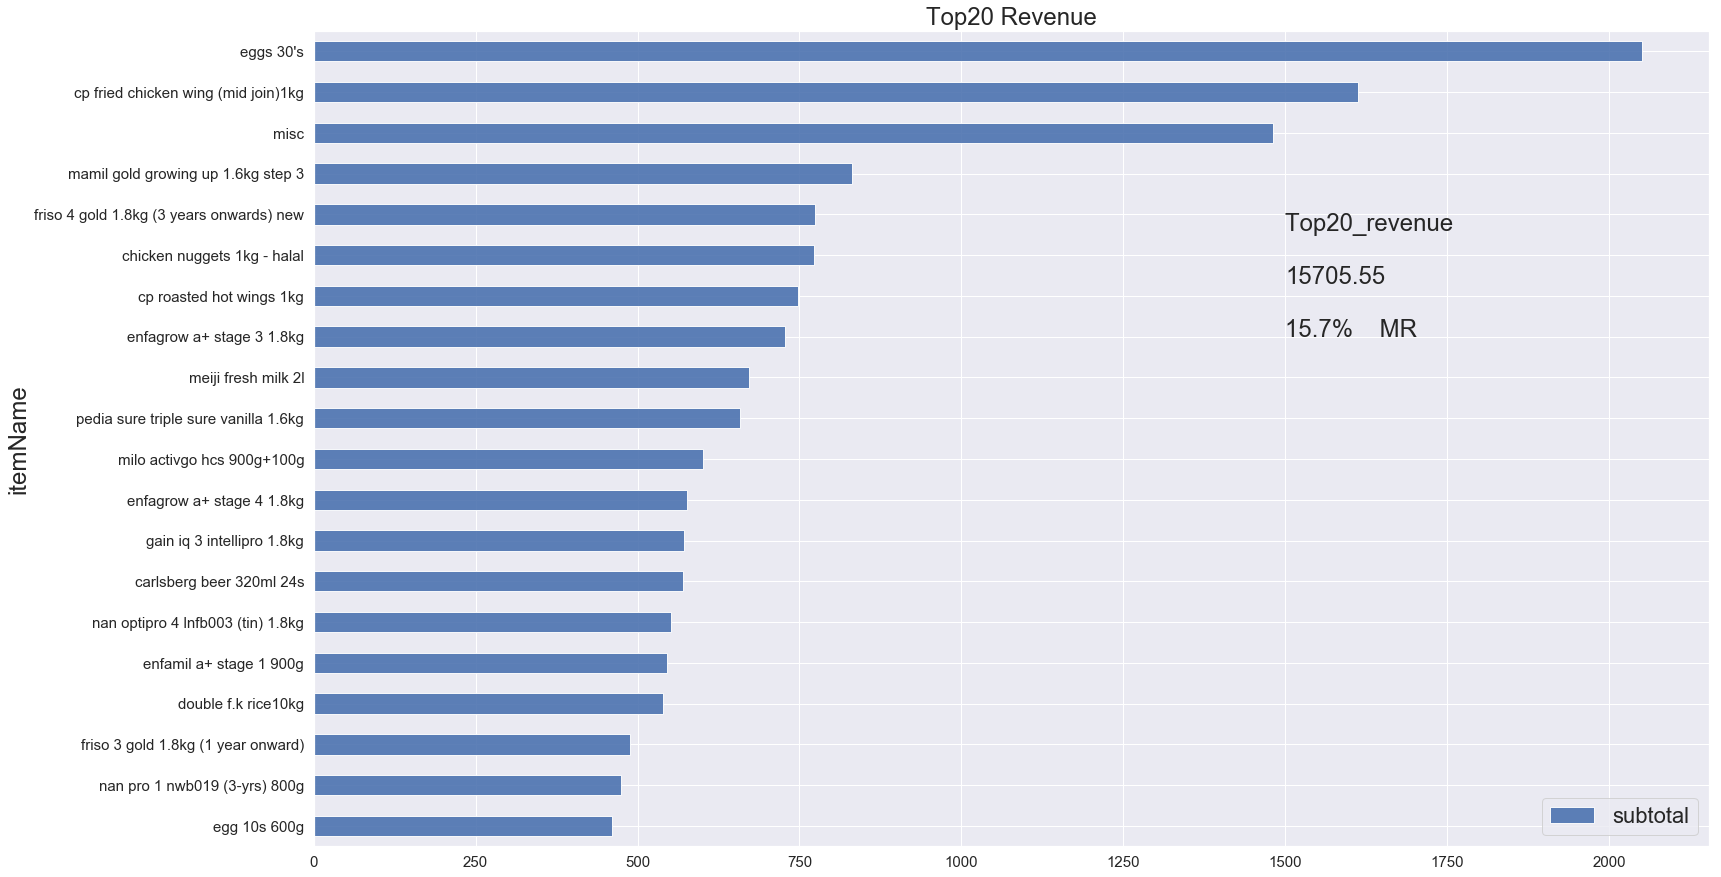

In [18]:
ax = result_top20_revenue_item.plot(kind='barh',figsize=(25,15),fontsize=15,grid=True,alpha=.9,title='Top20 Revenue')
ax.text(1500,7, 'Top20_revenue   \n\n'+str(top_20_revenue)
       +'\n\n' + str(top_20_revenue_ratio)+'%' + '    MR')
ax.invert_yaxis()

In [19]:
top20_rev_hot = np.union1d(result_top20_revenue_item.index.values,result_top20_hot_item.index.values)
print('collect  ',len(top20_rev_hot),'  items')
print(top20_rev_hot)

collect   34   items
['aatas cat tuna snapper 80g' 'carlsberg beer 320ml 24s'
 "chew's fresh eggs 10's" 'chicken nuggets 1kg - halal' 'coke 320ml'
 'cp fried chicken wing (mid join)1kg' 'cp roasted hot wings 1kg'
 'dasani drinking water 250ml' 'double f.k rice10kg' 'egg 10s 600g'
 "eggs 10's" "eggs 30's" 'enfagrow a+ stage 3 1.8kg'
 'enfagrow a+ stage 4 1.8kg' 'enfamil a+ stage 1 900g'
 'f&n sweetened creamer 500g' 'friso 3 gold 1.8kg (1 year onward)'
 'friso 4 gold 1.8kg (3 years onwards) new' 'gain iq 3 intellipro 1.8kg'
 'gardenia enriched white bread 400g' 'ice mountain 600ml'
 'kara cream coconut milk 200ml' 'maggi 2-minn curry mp (5x79g)'
 'mamil gold growing up 1.6kg step 3' 'meiji fresh milk 2l'
 'milo activgo hcs 900g+100g' 'misc' 'nan optipro 4 lnfb003 (tin) 1.8kg'
 'nan pro 1 nwb019 (3-yrs) 800g' 'pedia sure triple sure vanilla 1.6kg'
 'pokka jasmine green tea 1.5l' 'top 1 enriched white 400+100g'
 'y/l eggs 10s' 'yeo soy bean milk 350ml']


In [20]:
# top20_rev_hot.tolist()[:5]
#result_top20_revenue_item.index.values.tolist()

In [21]:
grouped = df_basket[['itemName','quantity','subtotal']].groupby(by=['itemName'],as_index=False)\
.sum().sort_values(by='quantity',ascending=False)
df_top20_rev_hot = grouped[grouped.itemName.isin(top20_rev_hot.tolist())]
df_top20_rev_hot = df_top20_rev_hot.eval('unit_price = subtotal / quantity')
df_top20_rev_hot['top_20_rev'] = 1 * df_top20_rev_hot.itemName.isin(result_top20_revenue_item.index.values.tolist())
df_top20_rev_hot['top_20_hot'] = 1 * df_top20_rev_hot.itemName.isin(result_top20_hot_item.index.values.tolist())

In [22]:
fresh_dic = {"eggs 30's": 1,"misc": 0,"dasani drinking water 250ml": 0,"coke 320ml": 0,'egg 10s 600g': 1,
            'pokka jasmine green tea 1.5l': 0 ,"eggs 10's": 1 ,'cp fried chicken wing (mid join)1kg': 0 ,'f&n sweetened creamer 500g':0,'meiji fresh milk 2l': 1 ,
            'gardenia enriched white bread 400g': 1,'ice mountain 600ml': 0, 'maggi 2-minn curry mp (5x79g)': 0, "chew's fresh eggs 10's":1,"top 1 enriched white 400+100g":1,
            "chicken nuggets 1kg - halal": 0, "yeo soy bean milk 350ml": 0, "aatas cat tuna snapper 80g": 0, "kara cream coconut milk 200ml":0,"y/l eggs 10s": 1,
            'milo activgo hcs 900g+100g': 0, "cp roasted hot wings 1kg": 0,"double f.k rice10kg":0,'friso 4 gold 1.8kg (3 years onwards) new':0,"mamil gold growing up 1.6kg step 3":0,
            "carlsberg beer 320ml 24s":0,'nan optipro 4 lnfb003 (tin) 1.8kg':0,'enfamil a+ stage 1 900g':0,"enfagrow a+ stage 3 1.8kg":0,"nan pro 1 nwb019 (3-yrs) 800g":0,
            "pedia sure triple sure vanilla 1.6kg": 0,"enfagrow a+ stage 4 1.8kg":0, "gain iq 3 intellipro 1.8kg":0,"friso 3 gold 1.8kg (1 year onward)":0}

len(list(fresh_dic.values()))
df_top20_rev_hot['fresh'] = list(fresh_dic.values())
# df_top20_rev_hot

In [23]:
category_dic = {"eggs 30's": 'egg',"misc": 'misc',"dasani drinking water 250ml": 'drink',"coke 320ml": 'drink','egg 10s 600g': 'egg',
            'pokka jasmine green tea 1.5l': 'drink' ,"eggs 10's": 'egg' ,'cp fried chicken wing (mid join)1kg': 'frozen food' ,'f&n sweetened creamer 500g':'instant drink','meiji category milk 2l': 'milk' ,
            'gardenia enriched white bread 400g': 'bread','ice mountain 600ml': 'drink', 'maggi 2-minn curry mp (5x79g)': 'meggi', "chew's category eggs 10's":'egg',"top 1 enriched white 400+100g":'bread',
            "chicken nuggets 1kg - halal": 'frozen food', "yeo soy bean milk 350ml": 'drink', "aatas cat tuna snapper 80g": 'cat staff', "kara cream coconut milk 200ml": 'drink',"y/l eggs 10s": 'egg',
            'milo activgo hcs 900g+100g': 'instant drink', "cp roasted hot wings 1kg": 'frozen food',"double f.k rice10kg":'rice','friso 4 gold 1.8kg (3 years onwards) new':
            "milk powder","mamil gold growing up 1.6kg step 3":"milk powder",
            "carlsberg beer 320ml 24s":'wine','nan optipro 4 lnfb003 (tin) 1.8kg':'milk powder','enfamil a+ stage 1 900g':'milk powder',"enfagrow a+ stage 3 1.8kg":'milk powder',"nan pro 1 nwb019 (3-yrs) 800g":'milk powder',
            "pedia sure triple sure vanilla 1.6kg": 'milk powder',"enfagrow a+ stage 4 1.8kg":'milk powder', "gain iq 3 intellipro 1.8kg":'milk powder',"friso 3 gold 1.8kg (1 year onward)":'milk powder'}

len(list(category_dic.values()))
df_top20_rev_hot['category_1'] = list(category_dic.values())
# df_top20_rev_hot

In [24]:
df_top20_rev_hot.groupby(by=['category_1']).sum().sort_values(by=['subtotal'],ascending=True)['subtotal'].sum() / this_month_revenue

0.18209012660054535

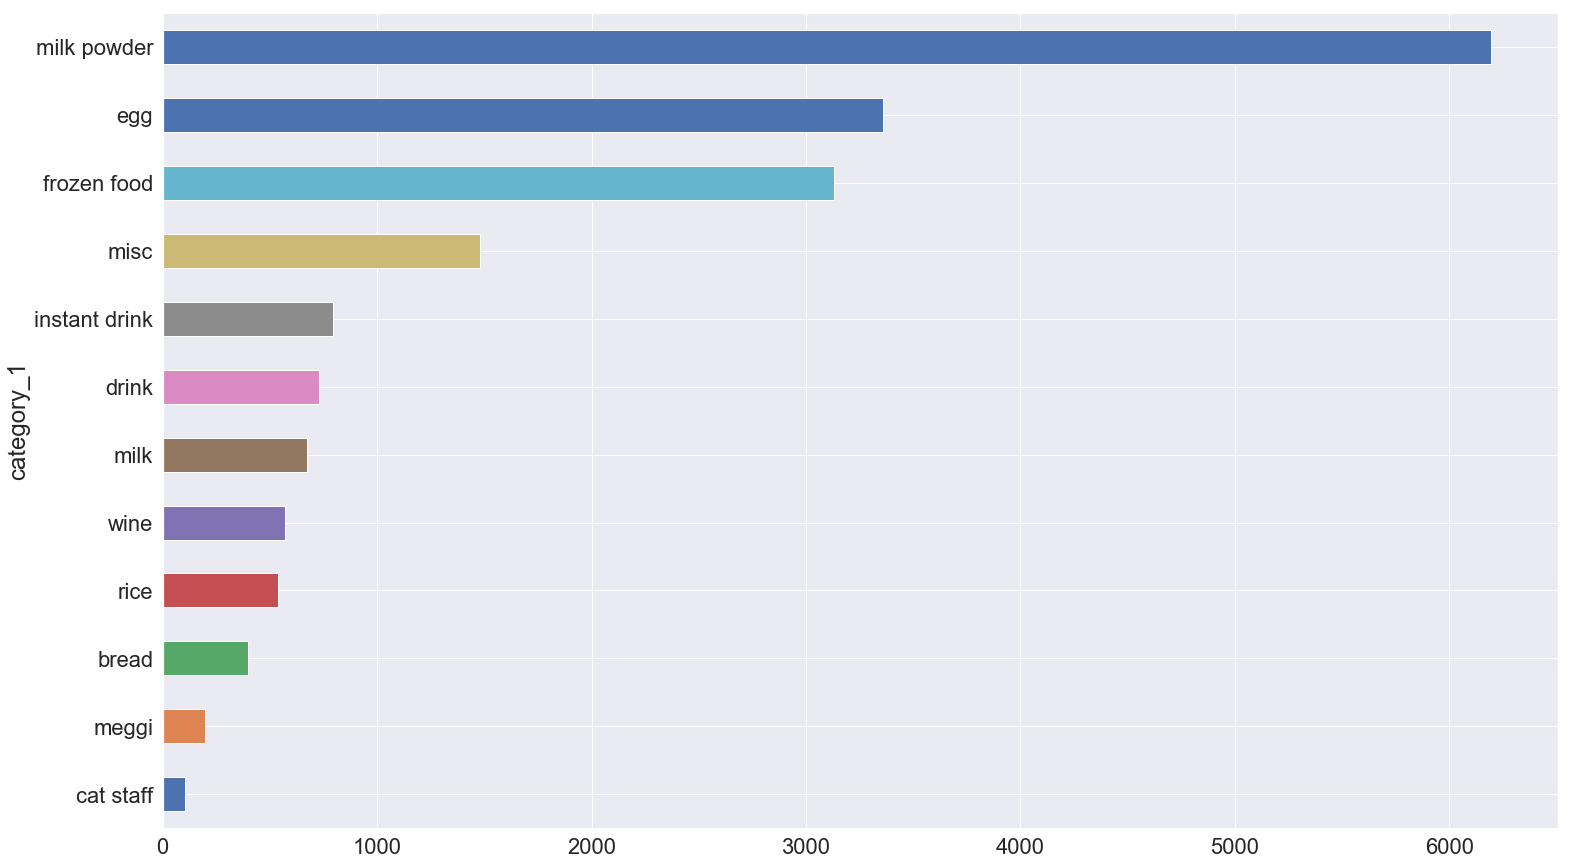

In [25]:
df_top20_rev_hot.groupby(by=['category_1']).sum().sort_values(by=['subtotal'],ascending=True)['subtotal'].plot(kind='barh',figsize=(25,15))

In [26]:
df_top20_rev_hot = df_top20_rev_hot.reset_index().drop(labels=['index'],axis=1)
df_top20_rev_hot['subtotal_int'] = df_top20_rev_hot['subtotal'].astype('int')

In [27]:
display(df_top20_rev_hot.head())
display(tidy_top20_hot_items.head())
df_category_grouped = df_top20_rev_hot[['category_1','subtotal']].groupby(by=['category_1'],as_index=False).sum()
df_category_grouped['subtotal_int'] = df_category_grouped['subtotal'].astype('int')

itemName  quantity  subtotal  unit_price  top_20_rev  \
0                    eggs 30's       373   2051.50    5.500000           1   
1                         misc       359   1481.25    4.126045           1   
2  dasani drinking water 250ml       331    100.10    0.302417           0   
3                   coke 320ml       313    157.40    0.502875           0   
4                 egg 10s 600g       215    460.40    2.141395           1   

   top_20_hot  fresh category_1  subtotal_int  
0           1      1        egg          2051  
1           1      0       misc          1481  
2           1      0      drink           100  
3           1      0      drink           157  
4           1      1        egg           460

itemName  quantity
0                    eggs 30's       373
1                         misc       359
2  dasani drinking water 250ml       331
3                   coke 320ml       313
4                 egg 10s 600g       215

In [28]:
# df_top20_rev_hot[['subtotal_int']] = df_top20_rev_hot[['subtotal']].astype(int)

In [29]:
# barh
# pass y_axis
ch = chartify.Chart(y_axis_type='categorical',blank_labels=True,layout='slide_100%')
ch.plot.bar(data_frame = df_category_grouped,
       categorical_columns=['category_1'],
       numeric_column='subtotal_int',
        color_column='category_1',
        categorical_order_ascending=True)

ch.plot.text(data_frame=df_category_grouped,
           categorical_columns='category_1',
           numeric_column='subtotal',
           text_column='subtotal_int',
           categorical_order_ascending=True)


ch.set_title('Top 20 hottest & Top 20 Revenue category')
ch.axes.set_xaxis_label('subtotal')
ch.axes.set_yaxis_label('category')
ch.axes.set_xaxis_range(0,7000)
# hide axis
ch.axes.hide_xaxis()
ch.show()

In [30]:
'''display(df_top20_rev_hot.head())
ch = chartify.Chart(x_axis_type='log',y_axis_type='log')
ch.plot.scatter(data_frame = df_top20_rev_hot,
               x_column = 'quantity',
               y_column = 'unit_price',
               color_column = 'itemName')
ch.style.color_palette.reset_palette_order()
ch.plot.text(data_frame= df_top20_rev_hot,
            x_column = 'quantity',
            y_column = 'unit_price',
            text_column = 'itemName',
            color_column = 'itemName',
            x_offset=1,
            y_offset=-1,
            font_size='20pt')
ch.axes.set_xaxis_range(0,3000)
ch.axes.set_yaxis_range(0,300)
ch.figure.legend.clear()
ch.show()''';

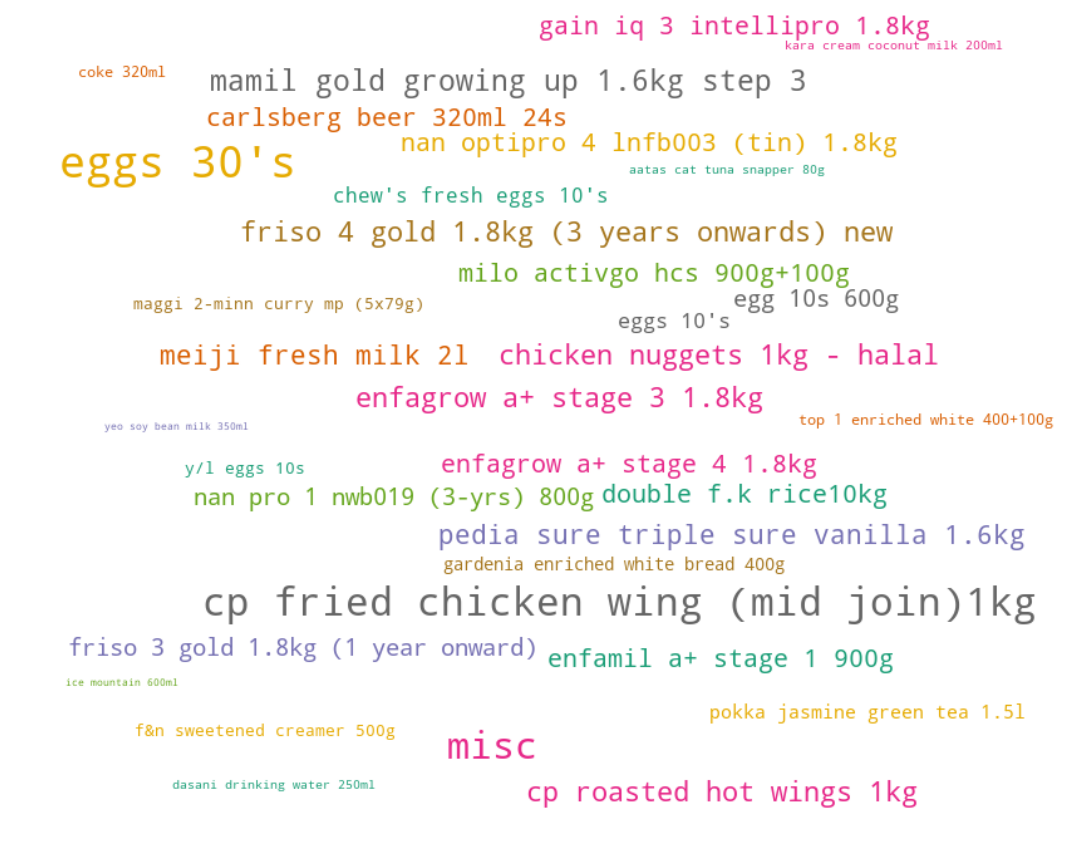

In [31]:
# make dictionary
d = {}
for a, x in df_top20_rev_hot[['itemName','subtotal_int']].values:
    d[a] = x


wordcloud = WordCloud(width=800,height=650,max_font_size=35,
                      background_color="white",prefer_horizontal=1,colormap=matplotlib.cm.Dark2)
wordcloud.generate_from_frequencies(frequencies=d)
fig,ax = plot.subplots(figsize=(25,15))
plot.imshow(wordcloud, interpolation="bilinear")
plot.axis("off")
plot.show()
fig.savefig('top_hot_rev_world_cloud.svg')
# fig.savefig("QS_distribution.svg")

## Invertory management

In [32]:
fresh_dic = {}
for item, fresh_or_not in df_top20_rev_hot.query('fresh == 1')[['itemName','fresh']].values:
    fresh_dic[item] = fresh_or_not
fresh_dic
df_basket['fresh'] = df_basket.itemName.map(fresh_dic).fillna(0).astype('int')

In [33]:
# pd.to_datetime('12-11-2010 00:00', format='%d-%m-%Y %H:%M')
df_basket['timestamp'] = pd.to_datetime(df_basket['date'] +'-'+ df_basket['time'],format='%Y-%m-%d-%H:%M:%S')
# pd.to_datetime(df_basket.date.head())
df_basket['week'] = df_basket['timestamp'].dt.week
df_basket['week_day'] = df_basket['timestamp'].dt.weekday
df_basket['hour'] = df_basket['timestamp'].dt.hour

In [34]:
print(df_basket.query('fresh == 1').shape[0],'  receipts')
print(df_basket.query('fresh == 1').itemName.nunique(),'  items')
# display(df_basket.query('fresh == 1').head())
df_invetory_week = df_basket.query('fresh == 1').groupby(by=['itemName','week'],as_index=False).sum()
# display(df_invetory_week.head())
df_invetory_week['week_shift'] = df_invetory_week['week'] - 34
df_invetory_week['unit_price'] = (df_invetory_week['subtotal'] / df_invetory_week['quantity']).round(4)
df_invetory_week.head()

1169   receipts
8   items


itemName  week  price  quantity  subtotal   total  fresh  \
0  chew's fresh eggs 10's    35   33.6        15      42.0  150.20     12   
1  chew's fresh eggs 10's    36   67.2        30      84.0  454.50     24   
2  chew's fresh eggs 10's    37   39.2        14      39.2  142.30     14   
3  chew's fresh eggs 10's    38   75.6        29      81.2  292.30     27   
4  chew's fresh eggs 10's    39   44.8        20      56.0  248.35     16   

   week_day  hour  week_shift  unit_price  
0        67   135           1         2.8  
1        67   320           2         2.8  
2        23   155           3         2.8  
3        83   285           4         2.8  
4        43   194           5         2.8

In [177]:
# pivot and melted
pivot_inventory_week = pd.pivot_table(data=df_invetory_week,index='itemName',columns ='week_shift',values='quantity',
        aggfunc='sum',margins=True,margins_name='Monthly')
pivot_inventory_week = pivot_inventory_week.drop(labels=['Monthly'])

value_columns = pivot_inventory_week.columns
melted_data = pd.melt(pivot_inventory_week.reset_index(), # Need to reset the index to put "fruit" into a column.
                      id_vars='itemName',
                      value_vars=value_columns)
melted_data = melted_data.rename(columns={'value':'quantity'})
melted_data['quantity'] = melted_data['quantity'].astype('int')
melted_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
itemName      48 non-null object
week_shift    48 non-null object
quantity      48 non-null int32
dtypes: int32(1), object(2)
memory usage: 1.0+ KB


In [180]:
# chartify.color_palettes.show()
chartify.examples.plot_heatmap

In [182]:
ch = chartify.Chart(
        blank_labels=True,
        x_axis_type='categorical',
        y_axis_type='categorical')
ch.plot.heatmap(
        data_frame=melted_data,
        x_column='week_shift',
        y_column='itemName',
        color_column='quantity',
        color_palette='Blues',
        color_value_max=150,
        text_column='quantity',
        text_color='white')
# ch.style.set_color_palette(palette_type='sequential',palette='Blues')
ch.axes.set_xaxis_label('week')
ch.axes.set_yaxis_label('itemName')
ch.set_title('Fresh items invertory management')
ch.set_subtitle("items vs weeks ")
ch.show()

# of items soldout under 3 times :  1618


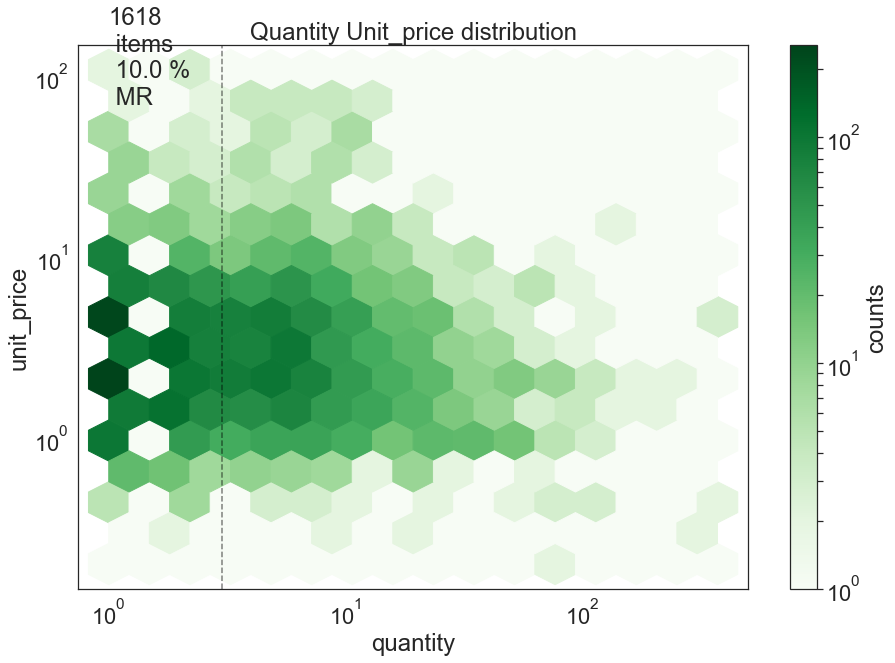

In [44]:
# An analysis of the items are very seldom buyed
# recomand to do something
# bottom 20
# under < 3
import matplotlib
sort_item = df_basket[['itemName','quantity','subtotal']].groupby(by=['itemName']).sum().sort_values(by='quantity',ascending=True)
under_3_revenue = 100 * np.around(sort_item[sort_item.quantity < 3].subtotal.sum() / this_month_revenue,decimals=3)
with sns.axes_style('white'):
    sort_item['unit_price'] = sort_item['subtotal'] / sort_item['quantity']
    # sort_item.plot(kind='hexbin',x='quantity',y='subtotal',figsize=(12,6),logx=True,logy=True)
    fig, ax = plot.subplots(figsize=(15,10))
    hb = ax.hexbin(x='quantity', y='unit_price', gridsize=15,xscale='log', yscale='log', cmap='Greens', norm=matplotlib.colors.LogNorm()
                         , data=sort_item)
    cb = fig.colorbar(hb,ax=ax)
    cb.set_label('counts');
    ax.set_xlabel('quantity');
    ax.set_ylabel('unit_price');
    ax.set_title('Quantity Unit_price distribution');
    ax.axvline(3,linestyle='dashed',c='black',alpha=.5)
    num_of_under_3 =  len(sort_item[sort_item.quantity < 3])
    ax.text(1,70, str(num_of_under_3) + '\n items' + '\n ' +str(under_3_revenue) + ' %  \n MR')
    print('# of items soldout under 3 times : ',num_of_under_3)

# of items soldout under 3 times and unit_price < 10 :  1517


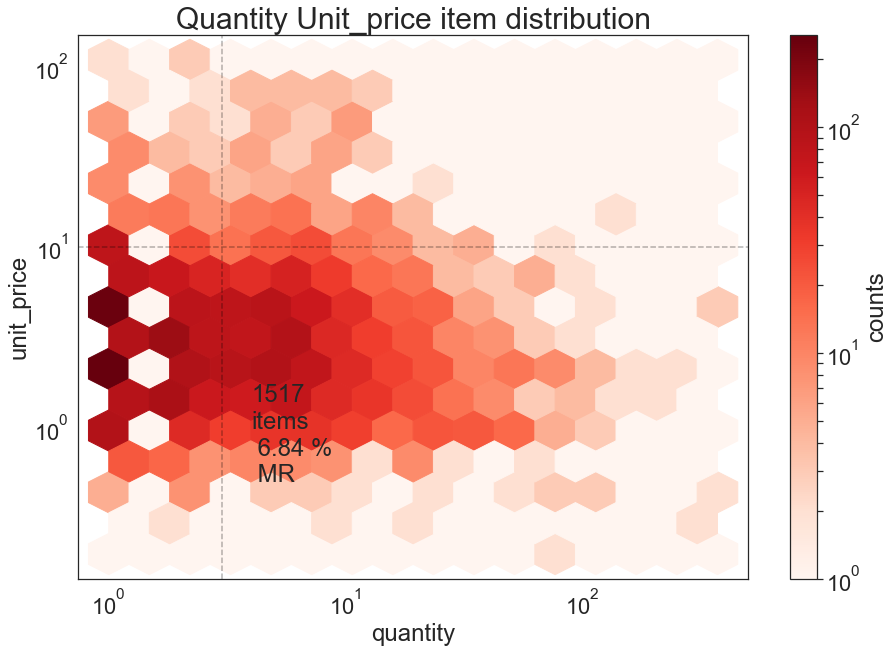

In [45]:
# An analysis of the items are very seldom buyed
# recomand to do something
# bottom 20
# under < 3
import matplotlib
sort_item = df_basket[['itemName','quantity','subtotal']].groupby(by=['itemName']).sum().sort_values(by='quantity',ascending=True)
sort_item['unit_price'] = sort_item['subtotal'] / sort_item['quantity']
under_3_unit_price_10_revenue = np.around(sort_item[(sort_item.quantity < 3) & (sort_item.unit_price < 10)].subtotal.sum() * 100 / this_month_revenue,decimals=2)
with sns.axes_style('white'):
    # sort_item.plot(kind='hexbin',x='quantity',y='subtotal',figsize=(12,6),logx=True,logy=True)
    fig, ax = plot.subplots(figsize=(15,10))
    hb = ax.hexbin(x='quantity', y='unit_price', gridsize=15,xscale='log', yscale='log', cmap='Reds', norm=matplotlib.colors.LogNorm()
                         , data=sort_item)
    cb = fig.colorbar(hb,ax=ax)
    cb.set_label('counts');
    ax.set_xlabel('quantity');
    ax.set_ylabel('unit_price');
    ax.set_title('Quantity Unit_price item distribution',fontsize=30);
    ax.axvline(3,linestyle='dashed',c='black',alpha=.3)
    ax.axhline(10,linestyle='dashed',c='black',alpha=.3)
    num_of_under_3 =  len(sort_item[(sort_item.quantity < 3) & (sort_item.unit_price < 10)])
    ax.text(4,0.5, str(num_of_under_3) + '\nitems' + '\n ' +str(under_3_unit_price_10_revenue) + ' %  \n MR')
    print('# of items soldout under 3 times and unit_price < 10 : ',num_of_under_3)
    fig.savefig("QS_distribution.svg")

In [46]:
df_basket.loc[df_basket.itemName.str.match('cold]'),'itemName'] = \
df_basket.loc[df_basket.itemName.str.match('cold]'),'itemName'].str.lstrip('cold]')

In [47]:
# df_basket[df_basket.itemName == 'dasani drinking water 250ml']

In [48]:
df_basket = df_basket.eval('unit_price = subtotal / quantity')
result_bottom20_item = df_basket[['itemName','quantity','unit_price']].groupby(by=['itemName']).sum().sort_values(by=['quantity','unit_price'],ascending=True).head(21);
cm = sns.light_palette("red", as_cmap=True)
s = result_bottom20_item.iloc[1:21].sort_values(by=['unit_price'],ascending=True).style.background_gradient(cmap=cm)
s

# market basket analysis

In [49]:
mega_item = pd.read_csv('sku_dataset.csv')
mega_item.describe(include=['number','O'])
mega_item.isnull().sum() / len(mega_item)

item_name        0.000000
brand_name       0.045902
category_name    0.645902
dtype: float64

In [50]:
mega_item.head()

item_name   brand_name                        category_name
0  100% PEPPER POWDER 20G          NaN  nielsen_processed,nielsen_groceries
1  100% PEPPER POWDER 60G          NaN  nielsen_groceries,nielsen_processed
2           100 PLUS 1.5L  100plus,f&n                                  NaN
3          100 PLUS 500ML  100plus,f&n                                  NaN
4      100 PLUS 500ML (M)  100plus,f&n                                  NaN

In [51]:
mega_item['item_name'] = mega_item.item_name.str.lower()

merged = pd.merge(df_basket.rename(columns={'itemName':'item_name'})
                  ,mega_item,how='left',on=['item_name'])

In [52]:
# the missing
merged.category_name.isnull().sum() / len(merged)

0.747785446443128

In [53]:
# merged

In [54]:
merged.shape

(18401, 17)

In [55]:
%%time
df_shopping_list = df_basket[['receipt_id','itemName','quantity']]\
.pivot_table(columns='itemName',index='receipt_id',aggfunc=np.sum).fillna(0)

Wall time: 1.57 s


In [56]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1


df_shopping_list = df_shopping_list.applymap(encode_units)
df_shopping_list
print(df_shopping_list.head().iloc[:,5:5].index)
df_shopping_list.head().iloc[:,0:5].columns;

Index(['T3-733343', 'T3-733346', 'T3-733350', 'T3-733354', 'T3-733355'], dtype='object', name='receipt_id')


In [57]:
# indexing example 
print(df_shopping_list.head().iloc[:,5:5].index)
print(df_shopping_list.head().columns.values)
df_shopping_list.loc['T3-733343',('quantity','kampong salted chicken 800g')]

Index(['T3-733343', 'T3-733346', 'T3-733350', 'T3-733354', 'T3-733355'], dtype='object', name='receipt_id')
[('quantity', ' 100 plus 1.5l') ('quantity', ' 7 up 500ml')
 ('quantity', ' abc stout 323ml') ... ('quantity', 'zoo country 100g')
 ('quantity', 'zoo jungle cocoa 100g') ('quantity', 'zoo original 100g')]


1

In [58]:
df_shopping_list.shape

(5445, 3681)

In [59]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [60]:
df_shopping_list.loc[:,'quantity'].head().reset_index().columns

Index(['receipt_id', ' 100 plus 1.5l', ' 7 up 500ml', ' abc stout 323ml',
       ' anchor beer strong 500ml', ' dasani drinking water 250ml',
       ' h-two-o original 500ml', ' ice mountain 1.5l', ' pocari sweat 2l',
       ' pokka blueberry tea 500ml',
       ...
       'zip apc crystal spring 1.8l', 'zip apc lavender 1.8l',
       'zip dwl ginger tea 900ml', 'zip dwl lemon 900ml', 'zip dwl lime 900ml',
       'zip dwl sea salt 900ml', 'zoo bears & bees 100g', 'zoo country 100g',
       'zoo jungle cocoa 100g', 'zoo original 100g'],
      dtype='object', name='itemName', length=3682)

In [61]:
test_df = df_shopping_list.loc[:,'quantity'].reset_index().drop(labels=['receipt_id'], axis=1)
test_df.head()

itemName   100 plus 1.5l   7 up 500ml   abc stout 323ml  \
0                      0            0                 0   
1                      0            0                 0   
2                      0            0                 0   
3                      0            0                 0   
4                      0            0                 0   

itemName   anchor beer strong 500ml   dasani drinking water 250ml  \
0                                 0                             0   
1                                 0                             0   
2                                 0                             0   
3                                 0                             0   
4                                 0                             0   

itemName   h-two-o original 500ml   ice mountain 1.5l   pocari sweat 2l  \
0                               0                   0                 0   
1                               0                   0                 0   
2                               0                   0                 0   
3                               0                   0                 0   
4                               0                   0                 0   

itemName   pokka blueberry tea 500ml   pokka ice lemon tea 500ml  \
0                                  0                           0   
1                                  0                           0   
2                                  0                           0   
3                                  0                           0   
4                                  0                           0   

itemName        ...          zip apc crystal spring 1.8l  \
0               ...                                    0   
1               ...                                    0   
2               ...                                    0   
3               ...                                    0   
4               ...                                    0   

itemName  zip apc lavender 1.8l  zip dwl ginger tea 900ml  \
0                             0                         0   
1                             0                         0   
2                             0                         0   
3                             0                         0   
4                             0                         0   

itemName  zip dwl lemon 900ml  zip dwl lime 900ml  zip dwl sea salt 900ml  \
0                           0                   0                       0   
1                           0                   0                       0   
2                           0                   0                       0   
3                           0                   0                       0   
4                           0                   0                       0   

itemName  zoo bears & bees 100g  zoo country 100g  zoo jungle cocoa 100g  \
0                             0                 0                      0   
1                             0                 0                      0   
2                             0                 0                      0   
3                             0                 0                      0   
4                             0                 0                      0   

itemName  zoo original 100g  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  

[5 rows x 3681 columns]

In [62]:
%%time
frequent_itemsets = apriori(test_df,min_support=0.001,use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values(by='support',ascending=False)
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.2)
# rules

Wall time: 29 s


* E.g
* df_shopping_list.loc[:,('quantity',"eggs 30's")].sum() <-- # of eggs basket / df_shopping_list.shape[0] <-- number of basket

In [63]:
# get rid of frozenset 
print(frequent_itemsets.shape)
display(frequent_itemsets.head())
[list(x)[0] for x in frequent_itemsets.itemsets.values]
freq_itemsets = pd.DataFrame({'support':frequent_itemsets.support,
             'itemsets':[list(x)[0] for x in frequent_itemsets.itemsets.values]})
display(freq_itemsets.head())

(886, 2)


support                              itemsets
202  0.060973                           (eggs 30's)
200  0.030670                        (egg 10s 600g)
510  0.028650                                (misc)
201  0.028099                           (eggs 10's)
291  0.020386  (gardenia enriched white bread 400g)

support                            itemsets
202  0.060973                           eggs 30's
200  0.030670                        egg 10s 600g
510  0.028650                                misc
201  0.028099                           eggs 10's
291  0.020386  gardenia enriched white bread 400g

In [64]:
pd.set_option('display.max_rows',150)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0)
rules

antecedents  \
0                 (meadow lea margarine original 500g)   
1                           (scs unsalted butter 227g)   
2                                          (eggs 30's)   
3                      (top 1 enriched white 400+100g)   
4                      (maggi tomato ketchup 475g+20%)   
5                        (maggi chilli sauce hcs 500g)   
6                       (pokka jasmine green tea 1.5l)   
7                                      (coke 1.5l (m))   
8                                          (eggs 30's)   
9                  (sunshine enr softwhite bread 550g)   
10                         (gardenia jumbo bread 600g)   
11                                         (eggs 30's)   
12                                         (eggs 30's)   
13                               (meiji fresh milk 2l)   
14                                         (eggs 30's)   
15               (cp fried chicken wing (mid join)1kg)   
16                       (chicken nuggets 1kg - halal)   
17                       (perdix chicken sausage 340g)   
18                                         (eggs 30's)   
19                       (chicken nuggets 1kg - halal)   
20             (fancy feast savory salmon classic 85g)   
21                     (fancy feast seafood feast 85g)   
22                     (fancy feast seafood feast 85g)   
23            (fancy feast ocean whitefish & tuna 85g)   
24                                         (eggs 30's)   
25                        (milo activgo hcs 900g+100g)   
26                          (cp roasted hot wings 1kg)   
27               (cp fried chicken wing (mid join)1kg)   
28                                         (eggs 30's)   
29                (gardenia enriched white bread 400g)   
30                                         (eggs 30's)   
31                       (maggi chilli sauce hcs 500g)   
32               (cp fried chicken wing (mid join)1kg)   
33                       (chicken nuggets 1kg - halal)   
34                      (aatas cat tuna & sardine 80g)   
35                       (atas cat tuna & tilapia 80g)   
36                                         (eggs 30's)   
37                     (maggi 2-minn curry mp (5x79g))   
38                   (sing long rice cake slices 500g)   
39                    (sing long rice cake strip 500g)   
40                   (fancy feast roasted chicken 85g)   
41                    (fancy feast chicken chunky 85g)   
42                                         (eggs 30's)   
43                             (mg dawn sweetened 1kg)   
44                                      (egg 10s 600g)   
45                 (sunshine enr softwhite bread 550g)   
46                                         (eggs 30's)   
47                                   (f/man salt 500g)   
48                   (hs istimewa cream crackers 428g)   
49                                         (eggs 30's)   
50                                         (eggs 30's)   
51                         (mg uht full cream milk 1l)   
52                                         (eggs 30's)   
53                       (perdix chicken sausage 340g)   
54                                         (eggs 30's)   
55                             (prima plain flour 1kg)   
56        (super value enriched white bread 400g+200g)   
57                                         (eggs 30's)   
58              (f&n evaporated filled milk (8%) 400g)   
59                        (f&n sweetened creamer 500g)   
60             (fancy feast savory salmon classic 85g)   
61            (fancy feast ocean whitefish & tuna 85g)   
62                    (fanta mango passion fruit 1.5l)   
63                            (fanta fruit punch 1.5l)   
64                  (maggi 2-minn curry letup (5x79g))   
65                   (maggi 2-minn asam laksa (5x78g))   
66                   (maggi 2-minn chicken mp (5x77g))   
67                     (maggi 2-minn curry mp (5x79g))   
68                     (maggi 2-minn curr

In [65]:
thres_hold = (rules.confidence < 0.9) & (rules.lift < 10)
print(rules[thres_hold].shape)
rules_filted = rules[thres_hold].sort_values(by=['confidence','lift','support'],ascending=False)
rules_filted = rules_filted.drop(labels=['leverage','conviction'],axis=1)
rules_filted_sorted = rules_filted.sample(frac=0.2,random_state=2).sort_values(by=['lift'],ascending=False).round(4)
rules_filted_sorted['lift'] = rules_filted_sorted['lift'].round(1)
rules_filted_sorted['antecedents'] = [list(x)[0] for x in rules_filted_sorted.antecedents.values]
rules_filted_sorted['consequents'] = [list(x)[0] for x in rules_filted_sorted.consequents.values]
rename_dic={'antecedents':'anteced','consequents':'conseq','antecedent support':'a_supp','consequent support':'c_supp',
           'support':'supp'}
rules_filted_sorted = rules_filted_sorted.rename(columns=rename_dic)
rules_filted_sorted.style.bar(subset=['lift'],align='zero',color='lightgreen')
# rules_filted_sorted
# rules_filted_sorted.style.bar(subset=['lift'],color='#d65f5f')
# df.style.bar(subset=['A', 'B'], align='mid', color=['#d65f5f', '#5fba7d'])

(58, 9)


### Costumer Description

In [66]:
# data clenaing
df_basket.query('total == 0').index
df_basket = df_basket.drop(df_basket.query('total == 0').index)
df_basket.shape

(18400, 15)

In [67]:
df_basket.query('total > 200')

itemName  price  quantity  subtotal  \
23                       golden pheonix rice 10kg  24.90         3     74.70   
25                      kimball tomato sauce 485g   1.50         2      3.00   
26         tai hua standard light soy sauce 640ml   2.70         1      2.70   
27                        ayam sardines tall 425g   3.40         3     10.20   
28                   sensodyne gum care tp 2x100g   6.20         1      6.20   
29                     darlie d/a toothpaste 250g   3.60         3     10.80   
30                     milo activgo hcs 900g+100g   7.90         4     31.60   
31                         maling green peas 397g   0.85         2      1.70   
32                                 f/man salt 3kg   1.30         1      1.30   
33                   rice vermicelli 400g tai sun   1.20         1      1.20   
34                       rice flour 600g elephant   1.30         1      1.30   
35               tai hua artificial vinegar 640ml   1.50         1      1.50   
36           soya sauce 645ml -green habhal salty   3.50         1      3.50   
37            soya sauce 645ml - red habhal sweet   3.50         1      3.50   
38                       lingham chilli sos 280ml   2.75         2      5.50   
39                                    duck oil 2l   4.50         4     18.00   
40                             golden corn oil 2l   7.50         1      7.50   
41                    lifebuoy b/wash mildcare 1l   7.20         1      7.20   
42                  lifebuoy b/wash naturepure 1l   7.20         1      7.20   
43                         glo d/w liq lime 1.35l   3.30         6     19.80   
44                   softlan blue 3l spring fresh   4.40         1      4.40   
45               kao magic toilet bleach 3px500ml   9.20         1      9.20   
46                breeze powder goodbye musty 4kg   8.90         1      8.90   
47                  breeze powder colour care 4kg   8.90         1      8.90   
179            s/h roti paratha f/p plain 20sx65g   6.95         1      6.95   
180             farmland french garlic bread 250g   2.60         2      5.20   
181            farmland burger feast beef 12x650g   5.80         2     11.60   
182                                     eggs 30's   5.50         1      5.50   
183       milo 3in1 actg-e promalt barley 18sx27g   5.90         2     11.80   
184                    milo activgo hcs 900g+100g   7.90         1      7.90   
185        nespray instant fortified 600g(refill)   8.90         1      8.90   
186                      lipton yellow label 100s   3.50         1      3.50   
187              milkmaid h/c condensed milk 392g   1.90         2      3.80   
188                maggi big curry flavour 5x111g   2.95         2      5.90   
189                 kara cream coconut milk 500ml   2.10         1      2.10   
190                 new moon mackerel tomato 425g   2.60         2      5.20   
191                           double f.k rice10kg  22.50         2     45.00   
192                          sis coarse sugar 2kg   3.30         1      3.30   
193                          sis coarse sugar 1kg   1.70         1      1.70   
194                          rex cuttle fish 425g   4.10         2      8.20   
195              skippy peanut butter creamy 462g   4.60         1      4.60   
196                    babas turmeric powder 125g   1.25         1      1.25   
197                  babas fish curry powder 250g   1.90         2      3.80   
198                           babas soup mix 125g   1.30         1      1.30   
199                    baba meat curry powder 1kg   7.50         1      7.50   
200        downy liquid sunrise fresh refill 1.8l   5.70         1      5.70   
201       lux shower cream magical sprll 600ml rf   3.50         2      7.00   
202          easy on starch reg linen 567g (20oz)   3.90         1      3.90   
203                        listerine cool mint 1l   7.50         1      7.50   
204                            piuxon ble

In [68]:
df_receipt_group = df_basket[['receipt_id','total']].groupby(by=['receipt_id'],as_index=False).head(1)
print(df_receipt_group.shape[0],'receipts')
df_receipt_group['log_total'] = np.log10(df_receipt_group[['total']]+1)
stats_df = df_receipt_group[['log_total']].describe([.25,.4,.45,.55,.60,.8,.9,.95])                                                                                                  
df_receipt_group.describe([.25,.4,.45,.55,.60,.8,.9,.95])                                                                                                  

5444 receipts


total    log_total
count  5444.000000  5444.000000
mean     17.790255     1.108115
std      24.791165     0.352590
min       0.400000     0.146128
25%       6.500000     0.875061
40%       9.000000     1.000000
45%      10.000000     1.041393
50%      11.400000     1.093422
55.0%    12.500000     1.130334
60%      13.800000     1.170262
80%      22.700000     1.374748
90%      35.300000     1.559907
95%      54.400000     1.743510
max     421.800000     2.626135

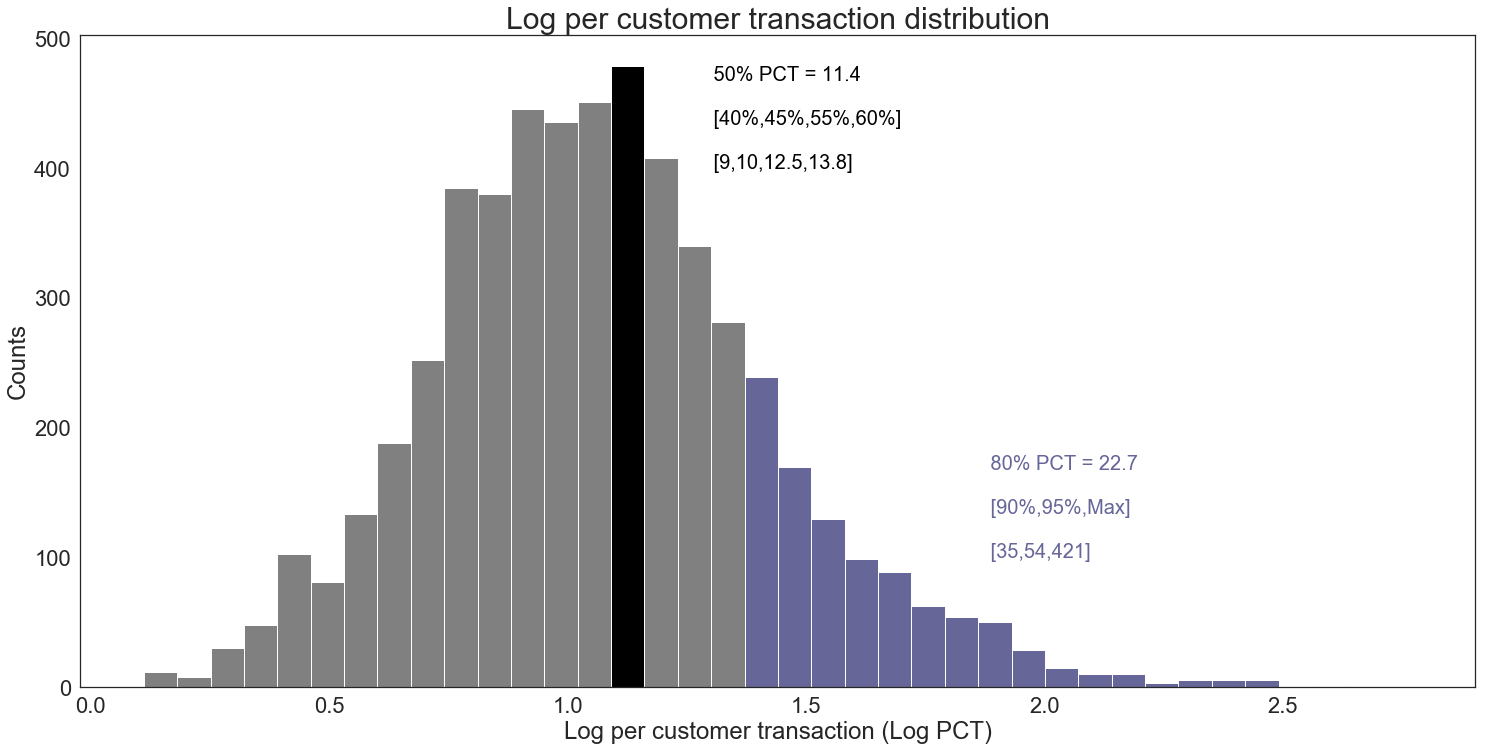

In [82]:
with sns.axes_style('white'):
    fig,ax = plot.subplots(figsize=(25,12))
    n, bins, patches = plot.hist(df_receipt_group[['log_total']].values, 
                             bins=np.arange(df_receipt_group[['log_total']].values.min(),
                                            df_receipt_group[['log_total']].values.max()+0.2, 0.07), align='left', color='gray')

    # 50% cum
    patches[14].set_fc('black')
    # 80% cum
    for bin in patches[18:]:
        # Use RGB color set
        bin.set_fc((0.4, 0.4, 0.6))
    ax.set_title('Log per customer transaction distribution',fontsize=30)
    ax.set_xlabel('Log per customer transaction (Log PCT)')
    ax.set_ylabel('Counts')
    # axvline for indicate
    # ax.axvline(stats_df.loc['80%','log_total'],color='r')
    ax.text(stats_df.loc['50%','log_total']+0.2,400, ' 50% PCT = 11.4 \n\n [40%,45%,55%,60%] \n\n [9,10,12.5,13.8]',fontsize=20,color='black')
    ax.text(stats_df.loc['80%','log_total']+0.5,100, ' 80% PCT = 22.7 \n\n [90%,95%,Max] \n\n [35,54,421]',fontsize=20,color= (0.4, 0.4, 0.6) )
    plot.show()
    fig.savefig('Log per customer transaction distribution.svg')

In [81]:
print(df_basket.query('total > 22.7').shape[0],'items ( including deplicated)')
print(df_basket.query('total > 22.7').groupby(by=['receipt_id'],as_index=False).sum()['receipt_id'].nunique(),'receipts')
gropued_80_up_receipt_items = df_basket.query('total > 22.7').groupby(by=['itemName'],as_index=False).sum().sort_values(by=['subtotal'],ascending=False)
print(gropued_80_up_receipt_items.shape[0],'items')
display(gropued_80_up_receipt_items.head())

6977 items ( including deplicated)
1086 receipts
2434 items


itemName  price  quantity  subtotal  \
451        cp fried chicken wing (mid join)1kg  775.0        90    1125.0   
1408        mamil gold growing up 1.6kg step 3  623.2        12     830.6   
777   friso 4 gold 1.8kg (3 years onwards) new  714.0        13     773.5   
622                  enfagrow a+ stage 3 1.8kg  565.6         9     727.2   
1774      pedia sure triple sure vanilla 1.6kg  575.4         8     657.6   

        total  fresh  week  week_day  hour  unit_price  
451   2869.70      0  2315       184   807       775.0  
1408  1189.60      0   332        34   123       623.2  
777   1117.55      0   439        48   171       714.0  
622    749.65      0   260        22    85       565.6  
1774   690.40      0   262         7    94       575.4

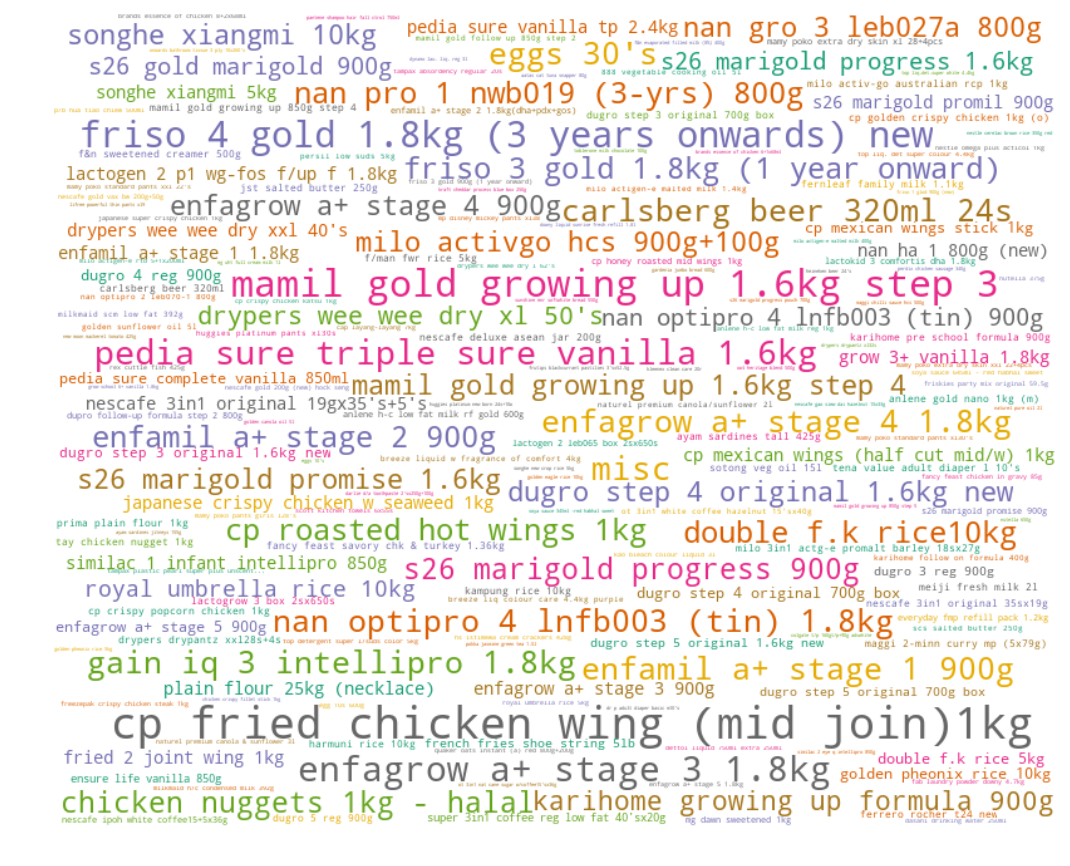

In [80]:
# make dictionary
d = {}
for a, x in gropued_80_up_receipt_items[['itemName','subtotal']].values:
    d[a] = x


wordcloud = WordCloud(width=800,height=650,max_font_size=35,
                      background_color="white",prefer_horizontal=1,colormap=matplotlib.cm.Dark2)
wordcloud.generate_from_frequencies(frequencies=d)
fig,ax = plot.subplots(figsize=(25,15))
plot.imshow(wordcloud, interpolation="bilinear")
plot.axis("off")
plot.show()
fig.savefig('gropued_80_up_receipt_items_world_cloud.svg')
# fig.savefig("QS_distribution.svg")

In [113]:
Cash_record

receipt_id   price  quantity  subtotal     total  fresh  week  week_day  \
0     T3-733343   15.80         2     15.80     31.60      0    70        10   
1     T3-733346   70.45         6     70.45    422.70      1   210        30   
2     T3-733350    1.40         1      1.40      1.40      0    35         5   
3     T3-733354    9.20         4      9.20     36.80      0   140        20   
4     T3-733355   61.90         2     61.90    123.80      0    70        10   
5     T3-733356    3.50         2      3.50      7.00      0    70        10   
6     T3-733357    4.90         1      4.90      4.90      0    35         5   
7     T3-733361   13.50         3     13.50     40.50      0   105        15   
8     T3-733366    7.70         3     13.30     26.60      0    70        10   
9     T3-733370  127.20        44    249.80   6463.20      0   840       120   
10    T3-733371    7.40         2      7.40     14.80      1    70        10   
11    T3-733381    0.95         2      1.90      1.90      0    35         5   
12    T3-733394    4.80         1      4.80      4.80      0    35         5   
13    T3-733395    0.80        12      9.60      9.60      0    35         5   
14    T3-733396    2.30         1      2.30      2.30      0    35         5   
15    T3-733415    4.35         2      4.35      8.70      0    70        10   
16    T3-733417   47.90         2     47.90     95.80      0    70        10   
17    T3-733419   19.40         4     19.40     77.60      1   140        20   
18    T3-733420    7.70         4      9.50     28.50      0   105        15   
19    T3-733421   21.00        14     30.60    148.00      0   175        25   
20    T3-733428   20.80         2     20.80     41.60      0    70        10   
21    T3-733430   15.40         8     18.30    109.80      1   210        30   
22    T3-733434    1.90         5     28.50     28.50      0    35         5   
23    T3-733439   12.25         6     12.25     73.50      1   210        30   
24    T3-733442   19.55         5     20.80     83.20      0   140        20   
25    T3-733445    6.50         4     26.00     26.00      0    35         5   
26    T3-733447   11.05         3     11.05     33.15      0   105        15   
27    T3-733448   29.00        15     36.50    401.50      0   385        55   
28    T3-733449   33.75         7     40.25    161.00      1   140        20   
29    T3-733451   21.70         7     21.70    151.90      0   245        35   
30    T3-733459    3.70         1      3.70      3.70      0    35         5   
31    T3-733462    6.30         1      6.30      6.30      0    35         5   
32    T3-733468    6.05         3      6.05     18.15      0   105        15   
33    T3-733470   31.65         9     35.30    247.10      0   245        35   
34    T3-733475    6.90         3      6.90     20.70      0   105        15   
35    T3-733476    6.80         1      6.80      6.80      0    35         5   
36    T3-733481   22.20         7     27.70    133.20      0   210        30   
37    T3-733483   15.45         3     15.45     46.35      0   105        15   
38    T3-733487   30.50         5     30.50    152.50      0   175        25   
39    T3-733488    1.20         4      2.00      3.60      0    70        10   
40    T3-733489    6.90         4      8.10     24.30      0   105        15   
41    T3-733490   24.55        16     38.20    305.60      0   280        40   
42    T3-733492   28.90         7     28.90    202.30      0   245        35   
43    T3-733496   27.95         4     27.95    111.80      0   140        20   
44    T3-733498   11.70         5     15.90     47.70      1   105        15   
45    T3-733501   19.05         7     21.75    130.50      0   210        30   
46    T3-733503    7.05         5      9.55     38.20      0   140        20   
47    T3-733515    6.80         1      6.80      6.80      0    35         5   
48    T3-733518    6.50         2      6.50     13.00      0    70        10   
49   

In [169]:
grouped_receipt_cash_net = df_basket.groupby(by=['receipt_id'],as_index=False).head(1)
print(grouped_receipt_cash_net['payment_method'].value_counts() / len(grouped_receipt_cash_net))
Cash_record = df_basket.query("payment_method == 'Cash'").groupby(by=['receipt_id'],as_index=False).sum()
Nets_record = df_basket.query("payment_method == 'Nets'").groupby(by=['receipt_id'],as_index=False).sum()
Cash_record['log_subtotal'] = np.log10(Cash_record[['subtotal']]+1)
Nets_record['log_subtotal'] = np.log10(Nets_record[['subtotal']]+1)
display(Cash_record[['subtotal','log_subtotal']].describe())
display(Nets_record[['subtotal','log_subtotal']].describe())
17.3 / 10.5

Cash    0.808597
Nets    0.191403
Name: payment_method, dtype: float64


subtotal  log_subtotal
count  4404.000000   4404.000000
mean     15.736898      1.070709
std      21.486211      0.340667
min       0.400000      0.146128
25%       5.900000      0.838849
50%      10.500000      1.060698
75%      17.900000      1.276462
max     374.200000      2.574263

subtotal  log_subtotal
count  1042.000000   1042.000000
mean     29.249328      1.313055
std      36.766164      0.350085
min       4.100000      0.707570
25%      10.425000      1.057853
50%      17.300000      1.262451
75%      31.675000      1.514215
max     421.800000      2.626135

1.6476190476190478

In [123]:
print(Cash_record.shape[0])
print(Nets_record.shape[0])

4404
1042


In [128]:
Cash_record = Cash_record.assign(payment_method = 'Cash')
Nets_record = Nets_record.assign(payment_method = 'Nets')

In [132]:
Cash_Nets_record_subtotal_dist = pd.concat([Cash_record,Nets_record],axis=0)
display(Cash_Nets_record_subtotal_dist.head())
print(Cash_Nets_record_subtotal_dist.shape[0],'receipts')

receipt_id  price  quantity  subtotal  total  fresh  week  week_day  hour  \
0  T3-733343  15.80         2     15.80   31.6      0    70        10    14   
1  T3-733346  70.45         6     70.45  422.7      1   210        30    42   
2  T3-733350   1.40         1      1.40    1.4      0    35         5     7   
3  T3-733354   9.20         4      9.20   36.8      0   140        20    28   
4  T3-733355  61.90         2     61.90  123.8      0    70        10    14   

   unit_price  log_subtotal payment_method  
0       15.80      1.225309           Cash  
1       70.45      1.854002           Cash  
2        1.40      0.380211           Cash  
3        9.20      1.008600           Cash  
4       61.90      1.798651           Cash

5446 receipts


In [163]:
'''ch = chartify.Chart(blank_labels=True, y_axis_type='density')
ch.set_title("KDE plot")
ch.plot.kde(
        data_frame=Cash_Nets_record_subtotal_dist,
        values_column='log_subtotal',
        color_column='payment_method')
ch.callout.text()
ch.show()''';

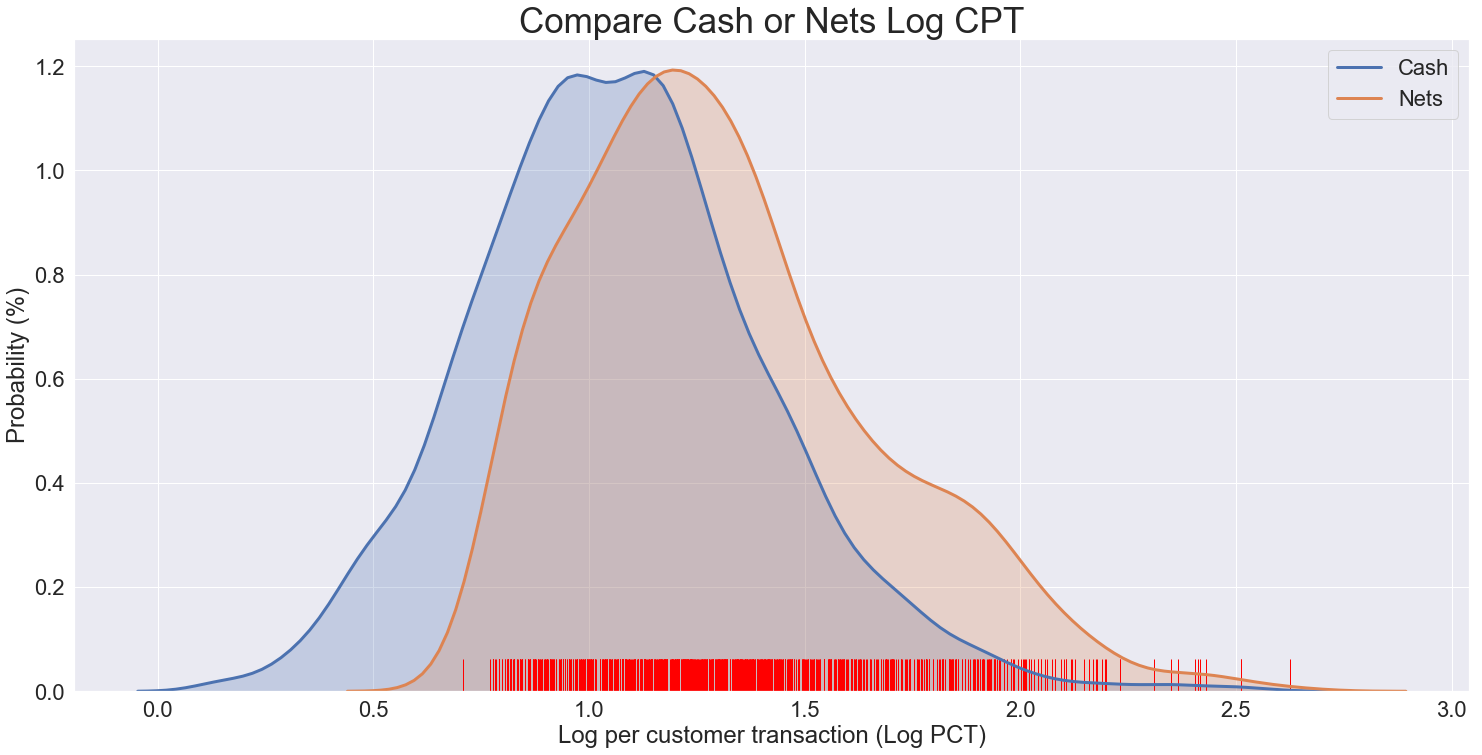

In [168]:
fig,ax = plot.subplots(figsize=(25,12))
sns.distplot(Cash_record['log_subtotal'], hist = False, kde = True, 
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = 'Cash',ax=ax)
sns.distplot(Nets_record['log_subtotal'], hist = False, kde = True, rug = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, rug_kws={'color': 'red'},
                  label = 'Nets',ax=ax)

ax.set_title('Compare Cash or Nets Log CPT',fontsize=35)
ax.set_xlabel('Log per customer transaction (Log PCT)')
ax.set_ylabel('Probability (%)')

ax.text(stats_df.loc['50%','log_total']+0.2,400, ' 50% PCT = 11.4 \n\n [40%,45%,55%,60%] \n\n [9,10,12.5,13.8]',fontsize=20,color='black')
# ax.text(stats_df.loc['80%','log_total']+0.5,100, ' 80% PCT = 22.7 \n\n [90%,95%,Max] \n\n [35,54,421]',fontsize=20,color= (0.4, 0.4, 0.6) )
plot.show()

# special case - "the milk powder"

In [184]:
milk_powder_list = df_top20_rev_hot.loc[df_top20_rev_hot.category_1 == 'milk powder','itemName'].values.tolist()
milk_powder_list[:3]

['friso 4 gold 1.8kg (3 years onwards) new',
 'mamil gold growing up 1.6kg step 3',
 'nan optipro 4 lnfb003 (tin) 1.8kg']

In [183]:
df_basket['itemName_exp'] = df_basket['itemName']
df_basket.loc[df_basket['itemName_exp'].isin(milk_pweder_list),'itemName_exp'] = 'milk powder'

In [186]:
%%time
df_shopping_list = df_basket[['receipt_id','itemName_exp','quantity']]\
.pivot_table(columns='itemName_exp',index='receipt_id',aggfunc=np.sum).fillna(0)
df_shopping_list = df_shopping_list.applymap(encode_units)
df_shopping_list.shape

CPU times: user 8.68 s, sys: 492 ms, total: 9.17 s
Wall time: 9.07 s


In [204]:
df_shopping_list.loc[:,('quantity',"milk powder")].sum()

70

In [199]:
%%time
frequent_itemsets_exp = apriori(df_shopping_list.loc[:,'quantity'],min_support=0.001,use_colnames=True)
frequent_itemsets_exp = frequent_itemsets_exp.sort_values(by='support',ascending=False)
# rules = association_rules(frequent_itemsets_exp, metric="lift", min_threshold=0.2)
# rules

CPU times: user 13.6 s, sys: 184 ms, total: 13.8 s
Wall time: 13.8 s


In [211]:
rules_exp = association_rules(frequent_itemsets_exp, metric="confidence", min_threshold=0)
# rules

In [238]:
# strip("0")

frequent_itemsets_exp[frequent_itemsets_exp.itemsets.str.contains('milk powder',regex=False)]

support       itemsets
488  0.012856  (milk powder)

In [246]:
# not work
pd.options.display.max_rows = 160
rules_exp

antecedents    ...     conviction
0                 (meadow lea margarine original 500g)    ...       4.135292
1                           (scs unsalted butter 227g)    ...       1.855080
2                                          (eggs 30's)    ...       1.035192
3                      (top 1 enriched white 400+100g)    ...       1.138570
4                      (maggi tomato ketchup 475g+20%)    ...       1.825866
5                        (maggi chilli sauce hcs 500g)    ...       1.490358
6                       (pokka jasmine green tea 1.5l)    ...       1.151185
7                                      (coke 1.5l (m))    ...       1.302369
8                                          (eggs 30's)    ...       1.026799
9                  (sunshine enr softwhite bread 550g)    ...       1.142482
10                         (gardenia jumbo bread 600g)    ...       1.085368
11                                         (eggs 30's)    ...       1.020542
12                               (meiji fresh milk 2l)    ...       1.060191
13                                         (eggs 30's)    ...       1.017493
14               (cp fried chicken wing (mid join)1kg)    ...       1.059135
15                                         (eggs 30's)    ...       1.015843
16                                         (eggs 30's)    ...       1.013824
17                       (chicken nuggets 1kg - halal)    ...       1.054956
18                       (perdix chicken sausage 340g)    ...       1.249041
19                       (chicken nuggets 1kg - halal)    ...       1.113759
20               (cp fried chicken wing (mid join)1kg)    ...       1.091139
21                          (cp roasted hot wings 1kg)    ...       1.174352
22                                         (eggs 30's)    ...       1.017481
23                        (milo activgo hcs 900g+100g)    ...       1.122749
24            (fancy feast ocean whitefish & tuna 85g)    ...       2.119536
25                     (fancy feast seafood feast 85g)    ...       2.791258
26             (fancy feast savory salmon classic 85g)    ...       5.485859
27                     (fancy feast seafood feast 85g)    ...       2.794343
28                                         (eggs 30's)    ...       1.009824
29                     (maggi 2-minn curry mp (5x79g))    ...       1.044832
30                                         (eggs 30's)    ...       1.003802
31                (gardenia enriched white bread 400g)    ...       1.011961
32                                         (eggs 30's)    ...       1.015658
33                       (maggi chilli sauce hcs 500g)    ...       1.126832
34                                         (eggs 30's)    ...       1.014717
35                             (mg dawn sweetened 1kg)    ...       1.105965
36                      (aatas cat tuna & sardine 80g)    ...       2.593792
37                       (atas cat tuna & tilapia 80g)    ...       2.593792
38               (cp fried chicken wing (mid join)1kg)    ...       1.071673
39                       (chicken nuggets 1kg - halal)    ...       1.076854
40                   (fancy feast roasted chicken 85g)    ...       3.655892
41                    (fancy feast chicken chunky 85g)    ...       1.995960
42                    (sing long rice cake strip 500g)    ...       8.986777
43                   (sing long rice cake slices 500g)    ...            inf
44                                         (eggs 30's)    ...       1.012721
45                       (perdix chicken sausage 340g)    ...       1.103356
46                         (mg uht full cream milk 1l)    ...       1.182478
47                                         (eggs 30's)    ...       1.015160
48                                         (eggs 30's)    ...       1.011408
49                   (hs istimewa cream crackers 428g)    ...       1.078882
50                  (maggi 2-minn curry letup (5x79g))    ...       1.344298
51                   (maggi 2-minn asam

In [ ]:
import networkx as nx

In [ ]:
nx.DiGraph

## Label the items

In [ ]:
merged.head(10)
unq_items = merged.item_name.unique().tolist()
print('# of unique items:  ', len(unq_items))

In [ ]:
merged[merged.item_name == 'friso 4 gold 1.8kg (3 years onwards) new']

In [ ]:
merged[merged.item_name.str.contains('lime',regex=False)]

In [ ]:
now = 40
unq_items[now:now+10]

In [ ]:
category_level_1 = ['chicken','instant milk','drink','checken sausage','ramen','maggi','drink','egg','maggi','drink',
                     'Dishwashing','toilet cleaner','oil','bread','oil','sweetened creamer','cheddar','coffee','coffee','cereal',
                   'maggie','coffee','rice','seasoning','seasoning','can','toothpaste','toothpaste','instant drink','vegetables',
                   'seasoning','rice vermicelli','rice flour','seasoning','seasoning','seasoning','seasoning','oil','oil','Body Wash',
                   'Body Wash','Dishwashing']
# category_level_1
item_cat_map = dict(zip(unq_items[:len(category_level_1)],category_level_1))
print('compelete: ' + str(len(category_level_1)) + '  items! ' + '  cheer up !')
item_cat_map
# merged[merged.item_name.str.contains('chicken',regex=False)]